<a href="https://colab.research.google.com/github/ranadeepbhuyan/ml-class/blob/master/working_final_Resunet2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install  keras-preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00


In [ ]:
!pip install sklearn

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Required datapaths
training_dataPath = r"/content/drive/MyDrive/training_dataset_nii/3d_to_2d_dataset"
mask_path = r"/content/drive/MyDrive/training_dataset_nii/3d_to_2d_mask"

In [ ]:
#fatching ids form data path
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_data_ids = [f.path for f in os.scandir(training_dataPath)]






In [ ]:
train_data_mask_ids = [f.path for f in os.scandir(mask_path)]

In [ ]:
len(train_data_ids)

41692

In [ ]:
len(train_data_mask_ids)

41704

In [ ]:

training_mask_ids = pathListIntoIds(train_data_mask_ids );
training_data_ids = pathListIntoIds(train_data_ids);

In [ ]:
training_data_ids.sort()
training_data_ids[0]

'UCSF-PDGM-0004_nifti-slice000_x.png'

In [ ]:
training_mask_ids.sort()
training_mask_ids[0]

'UCSF-PDGM-0004_nifti-slice000_x.png'

In [ ]:
def remove_unmatch_ids(dataset1,dataset2):
  for i in dataset1:
    if i not in dataset2:
      dataset1.remove(i)


In [ ]:
remove_unmatch_ids(training_data_ids,training_mask_ids)
remove_unmatch_ids(training_mask_ids,training_data_ids)

In [ ]:
len(training_data_ids)

41636

In [ ]:
len(training_mask_ids)

41636

In [ ]:
result = []
for i in training_mask_ids:
    if i not in training_data_ids:
      result.append(i)


In [ ]:
result

[]

In [ ]:
len(training_mask_ids)

41636

In [ ]:
len(training_data_ids)

41636

In [ ]:
def remove_png(dataset):
  x = []
  for i in range(0,len(dataset)):
    y = dataset[i].split('.png')[0]
    x.append(y)
  return x


In [ ]:
training_data_ids = remove_png(training_mask_ids)

In [ ]:
training_data_ids[20000]

'UCSF-PDGM-0047_nifti-slice160_x'

In [ ]:
len(training_data_ids)

41636

In [ ]:
#training_data_ids2=[]
#for i in range(20000,len(training_data_ids)):
  #training_data_ids2.append(training_data_ids[i])



In [ ]:
#len(training_data_ids2)

21636

In [ ]:
#removing the black images form the dataset
import cv2
final_training_ids = []
img_path = r"/content/drive/MyDrive/training_dataset_nii/3d_to_2d_dataset"
for i in range(0,20000):
  training_data_path = os.path.join(img_path, f'{training_data_ids[i]}.png');
# Load the image
  image = cv2.imread(training_data_path)

# Convert the image to grayscale
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Calculate the gray level
  gray_level = gray_image.max()

# append the mask_ids into a new list
  if gray_level > 175:
    final_training_ids.append(training_data_ids[i])




In [ ]:
#contain firts 20000 dataset
len(final_training_ids)

12770

In [ ]:
train_ids, val_ids = train_test_split(final_training_ids,test_size=0.2)

In [ ]:
len(train_ids)

10216

In [ ]:
len(val_ids)

2554

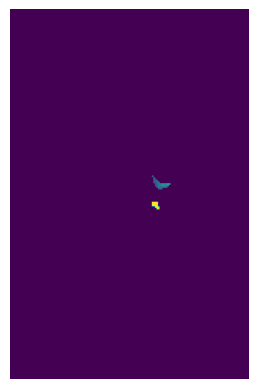

In [ ]:
from PIL import Image
#img_path = r"/content/drive/MyDrive/Colab Notebooks/BRTS/3ddatato2ddataofbrats /traindata2"
for i in range(0,1):
  mask_path1 = os.path.join(img_path, f'{final_training_ids[i]}.png');
  image_path = mask_path1

# Open the image using PIL
  image = Image.open(image_path)

# Display the image using matplotlib
  plt.imshow(image)
  plt.axis('off')  # Turn off axis ticks and labels
  plt.show()

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 128, img_w = 128, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'

    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth)
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = r"/content/drive/MyDrive/training_dataset_nii/3d_to_2d_dataset"

      #mask path
      mask_path = r"/content/drive/MyDrive/training_dataset_nii/3d_to_2d_mask"

      #reading the original image and the corresponding mask image
      data_path = os.path.join(img_path, f'{list_ids[i]}.png');
      img = io.imread(data_path)
      mask_path1 = os.path.join(mask_path, f'{list_ids[i]}.png');
      mask = io.imread(mask_path1)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)

      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising
      #img -= img.mean()
      #img /= img.std()

      #mask -= mask.mean()
      #mask /= mask.std()

      #Adding image to the empty array
      X[i,] = np.expand_dims(img, axis = 2)

      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)

    #normalizing y
    y = (y > 0).astype(int)

    return X, y

train_data = DataGenerator(train_ids,train_ids)
val_data = DataGenerator(val_ids, val_ids)

In [ ]:
# lets create model now
def resblock(X, f):
    '''
    function for creating res block
    '''

    X_copy = X  #copy of input

    # main path
    X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)

    # shortcut path
    X_copy = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)

    # Adding the output from main path and short path together
    X = Add()([X, X_copy])
    X = Activation('relu')(X)

    return X

def upsample_concat(x, skip):
    '''
    funtion for upsampling image
    '''
    X = UpSampling2D((2,2))(x)
    merge = Concatenate()([X, skip])

    return merge

In [ ]:
input_shape = (128,128,3)
X_input = Input(input_shape) #iniating tensor of input shape

# Stage 1
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D((2,2))(conv_1)

# stage 2
conv_2 = resblock(pool_1, 32)
pool_2 = MaxPool2D((2,2))(conv_2)

# Stage 3
conv_3 = resblock(pool_2, 64)
pool_3 = MaxPool2D((2,2))(conv_3)

# Stage 4
conv_4 = resblock(pool_3, 128)
pool_4 = MaxPool2D((2,2))(conv_4)

# Stage 5 (bottle neck)
conv_5 = resblock(pool_4, 256)
# Upsample Stage 1
up_1 = upsample_concat(conv_5, conv_4)
up_1 = resblock(up_1, 128)

# Upsample Stage 2
up_2 = upsample_concat(up_1, conv_3)
up_2 = resblock(up_2, 64)

# Upsample Stage 3
up_3 = upsample_concat(up_2, conv_2)
up_3 = resblock(up_3, 32)

# Upsample Stage 4
up_4 = upsample_concat(up_3, conv_1)
up_4 = resblock(up_4, 16)

# final output
out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)

seg_model = Model(X_input, out)
seg_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_27 (Conv2D)             (None, 128, 128, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_26 (BatchN  (None, 128, 128, 16  64         ['conv2d_27[0][0]']              
 ormalization)                  )                                                           

In [ ]:
# Define a custom loss function for ResUNet model
'''
actual link for refrence (https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py)
'''
from keras.losses import binary_crossentropy

epsilon = 1e-5
smooth = 1e-6

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [ ]:
adam = tf.keras.optimizers.Adam(lr = 0.001, epsilon = 0.1)
seg_model.compile(optimizer = adam,
                  loss = focal_tversky,
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=20
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-segModel-weights.hdf5",
                               verbose=1,
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [ ]:
h = seg_model.fit(train_data,
                  epochs = 15,
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )

Epoch 1/15
638/638 [==============================] - ETA: 0s - loss: 0.0856 - tversky: 0.9618
Epoch 1: val_loss improved from 0.09555 to 0.08335, saving model to ResUNet-segModel-weights.hdf5
638/638 [==============================] - 307s 481ms/step - loss: 0.0856 - tversky: 0.9618 - val_loss: 0.0834 - val_tversky: 0.9631 - lr: 0.0010
Epoch 2/15
638/638 [==============================] - ETA: 0s - loss: 0.0781 - tversky: 0.9655
Epoch 2: val_loss did not improve from 0.08335
638/638 [==============================] - 298s 466ms/step - loss: 0.0781 - tversky: 0.9655 - val_loss: 0.0886 - val_tversky: 0.9567 - lr: 0.0010
Epoch 3/15
638/638 [==============================] - ETA: 0s - loss: 0.0754 - tversky: 0.9670
Epoch 3: val_loss improved from 0.08335 to 0.06248, saving model to ResUNet-segModel-weights.hdf5
638/638 [==============================] - 297s 466ms/step - loss: 0.0754 - tversky: 0.9670 - val_loss: 0.0625 - val_tversky: 0.9747 - lr: 0.0010
Epoch 4/15
638/638 [==============

KeyboardInterrupt: ignored

In [ ]:
# list all data in history
print(h.h.keys())
# summarize history for accuracy
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(h.h['tversky'])
plt.plot(h.h['val_tversky'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

NameError: ignored